# Notebook to browse tree and find pair of relatives
A Package that can crowl pedigree data and return the pw. relatedness of every pair

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import h5py
import matplotlib.cm as cm
import itertools as it
import multiprocessing as mp
from queue import Queue
import itertools as it

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/"  # The Path on Harvard Cluster
    sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/python3/")  # hack to get development package first in path
    
elif socket_name.startswith("bionc"):
    print("Leipzig Cluster detected!")
    path = "/mnt/archgen/users/hringbauer/git/ibd_gurgy/"
    sys.path.append("/mnt/archgen/users/hringbauer/git/hapBLOCK/python3/") 
    
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']

from ibd_stats.funcs import find_relatives

bionc21
Leipzig Cluster detected!
/mnt/archgen/users/hringbauer/git/ibd_gurgy
CPU Count: 40


### Create a list of nodes

In [89]:
class Ind(object):
    """Class that stores parents, and whether visited."""
    name = ""
    mum = ""
    dad = ""
    output = False
    anc = -1 # How far away from a given sample
    anc1 = -1 # How far away from given sample 2
    
    def __init__(self, name="", mum="", dad=""):
        if len(name)>0:
            self.name = name   
        if len(mum)>0:
            self.set_mum(mum)  
        if len(dad)>0:
            self.set_dad(dad)
            
    def set_mum(self, mum):
        """Set Mum."""
        self.mum = mum
        
    def set_dad(self, dad):
        """Set Data"""
        self.dad = dad
        
    def get_mum(self):
        """Get Mum."""
        return self.mum
        
    def get_dad(self):
        """Get Dad"""
        return self.dad
    
    def get_parents(self):
        """Get Mum and Dad"""
        return self.mum, self.dad
        
    def show(self):
        """Print Summary Stats"""
        print(f"Name: {self.name}")
        print(f"Mum: {self.mum}")
        print(f"Dad: {self.dad}")

### Set up the tree

In [90]:
def set_up_node_list(df):
    """Set up List of all Nodes.
    Initialize to parent values"""

    names = df["t"].values

    inds = np.array([Ind(name=t) for t in df["t"]])
    print(f"Created {len(inds)} empty Individuals")

    ### Set all parents
    for i, row in df.iterrows():
        ind = inds[i]

        mum, dad = row["f"], row["m"]
        idx_m =  np.where(names==mum)[0]
        idx_d =  np.where(names==dad)[0]
        assert(len(idx_m)<2)
        assert(len(idx_d)<2)

        if len(idx_m)>0:
            mum = inds[idx_m[0]]
        ind.set_mum(mum)

        if len(idx_d)>0:
            dad = inds[idx_d[0]]
        ind.set_dad(dad)
        
    return inds

def find_node(name, inds):
    """Return Node of name name."""
    for i in inds:
        if i.name==name:
            return i
    raise RuntimeWarning(f"Individual {name} not found in Ind list")
    
def reset_ancs(inds):
    """Reset all ancestors to missing"""
    for i in inds:
        i.anc = -1
        i.anc1 = -1
        
def set_ancs(node, anc=0, output=False):
    """Starting from a Node, crawl
    to ancestors"""
    if output:
        print(f"Crowling Node {node.name}")
    if node.anc == -1:
        node.anc=anc
        
    mum, dad = node.get_parents()
    
    ancs1, ancs2 = 0, 0
    if isinstance(node.mum, Ind):
        ancs1 = set_ancs(node.mum, anc+1, output=output)
        
    if isinstance(node.dad, Ind):
        ancs2 = set_ancs(node.dad, anc+1, output=output)
    
    return ancs1 + ancs2 + 1

def find_common_ancs(node, anc1=0, output=False):
    """Starting from Node 2, crawl to ancestors.
    Return all common ancestors"""
    if output:
        print(f"Crowling Node {node.name}")
    
    if node.anc1 == -1:
        node.anc1=anc1
        
    #### Stop if common ancestor found
    if node.anc>=0:
        return node.anc, node.anc1
    
    #### Crowl to parents    
    mum, dad = node.get_parents()
    
    if isinstance(node.mum, Ind):
        found = find_common_ancs(node.mum, anc1+1, output=output)
        if found:
            return found
        
    if isinstance(node.dad, Ind):
        found = find_common_ancs(node.dad, anc1+1, output=output)
        if found:
            return found
    ### Return if Nothing found
    return False

def get_degree(anc1, anc2):
    """Return the degree of ancestry, and whether directly ancestral"""
    
    ### Directly Ancestral:
    if (anc1 == 0) or (anc2 == 0):
        return (anc1 + anc2, True)
    
    ### Avuncular:
    else:
        return (anc1 + anc2 -1, False)
    
### Set Ancestors of Individual
def get_relation_ship(name, name2, inds, 
                      reset=True, output=False):
    """Get relationship between name and name2 within node list inds"""
    if reset:
        reset_ancs(inds)
    
    if output:
        print(f"\nIndividual 1:")
    node = find_node(name, inds)
    set_ancs(node, anc=0, output=output)
    
    if output:
        print(f"\nIndividual 2:")
    node = find_node(name2, inds)
    ancs = find_common_ancs(node, anc1=0, output=output)
    
    if not ancs:
        return (0, False)
    
    anc1, anc2 = ancs    
    d = get_degree(anc1, anc2)
    if output:
        print(anc1, anc2)
        print(f"Degree: {d[0]}, Ancestral: {d[1]}")
    
    return d

# Load the data

In [91]:
#df = pd.read_csv("./data/tree/parents.tsv", sep="\t")
df = pd.read_csv("./data/tree/family_all.v2.tsv", sep="\t")
inds = set_up_node_list(df)

Created 115 empty Individuals


### Simple Test Run

In [92]:
d = get_relation_ship(name = "GRG087", name2 = "GRG084", 
                      inds=inds, output=True)
d


Individual 1:
Crowling Node GRG087
Crowling Node f37
Crowling Node GRG086
Crowling Node GRG027
Crowling Node GRG107
Crowling Node GRG088
Crowling Node GRG102
Crowling Node f1

Individual 2:
Crowling Node GRG084
Crowling Node f15
Crowling Node GRG088
4 2
Degree: 5, Ancestral: False


(5, False)

# Prepare All Relatives

In [93]:
df_iids = pd.read_csv("/mnt/archgen/users/hringbauer/output/ibd/GRG/iid72_v0.tsv", sep="\t", header=None)
iids = df_iids[0].str.split(".").str[0].values
print(f"Loaded {len(iids)} IIDs run in IBD")

#df = pd.read_csv("./data/tree/parents.tsv", sep="\t")
df = pd.read_csv("./data/tree/family_all.v2.tsv", sep="\t")
inds = set_up_node_list(df)
names = np.array([n.name for n in inds])

iids_both = np.array([i for i in iids if i in names])
print(f"Found {len(iids_both)} IIDs in both data sets")

#remove = ["GRG001", "GRG002"]
remove = []
iids_both = iids_both[~np.isin(iids_both, remove)]
print(f"Found {len(iids_both)} IIDs not flagged")

Loaded 72 IIDs run in IBD
Created 115 empty Individuals
Found 72 IIDs in both data sets
Found 72 IIDs not flagged


### Create Dataframe with all relatives

In [94]:
%%time
c = np.array(list(it.combinations(iids_both, 2)))
rel = np.zeros(len(c), dtype="int8")
anc = np.zeros(len(c), dtype="int8")
for i, p in enumerate(c):
    d = get_relation_ship(name = p[0], name2 = p[1], 
                      inds=inds, output=False)
    if d:
        rel[i] = d[0]
        anc[i] = d[1]
        
dft = pd.DataFrame({"iid1":c[:,0], "iid2":c[:,1], "rel":rel, "anc":anc})
dft["rel"].value_counts()

CPU times: user 85.9 ms, sys: 0 ns, total: 85.9 ms
Wall time: 95.6 ms


0     1573
5      189
4      173
6      165
3      126
7      111
2       80
8       60
1       55
9       21
10       3
Name: rel, dtype: int64

### Merge with IBD dataframe

In [95]:
df_ibd = pd.read_csv("/mnt/archgen/users/hringbauer/output/ibd/GRG/ibd_grg72_v0.tsv", sep="\t")
for c in ["iid1", "iid2"]:
    df_ibd[c] = df_ibd[c].str.split(".").str[0] 

df1 = pd.merge(dft, df_ibd, on=["iid1", "iid2"]) 

print(f"Merged {len(df1)}/{len(dft)} Entries!")
### If not create the same way - needs flipping!!!

Merged 2556/2556 Entries!


In [14]:
#df1.to_csv("./output/ibd+rel.tsv", sep="\t", index=False)
df1.to_csv("./output/ibd+rel.all.tsv", sep="\t", index=False)

# Do the Plotting

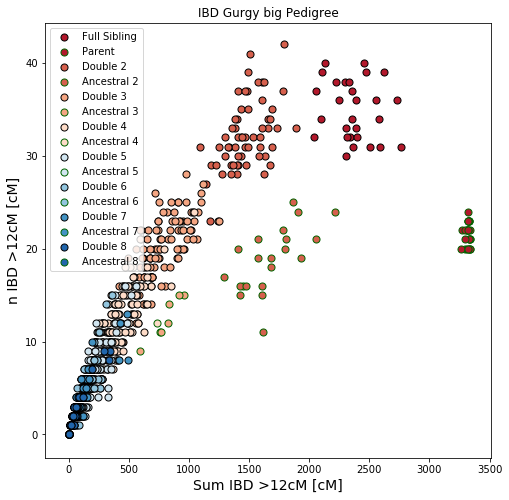

In [96]:
df_c = pd.read_csv("./data/tree/colors.tsv", sep="\t")
df1 = pd.read_csv("./output/ibd+rel.all.tsv", sep="\t")

min_cm = 12
s = 50
savepath = ""
figsize = (8,8)


plt.figure(figsize=figsize)
ax = plt.gca()

for _, row in df_c.iterrows():
    dft = df1[(df1["rel"]==row["rel"]) & (df1["anc"]==row["anc"])]
    
    if row["anc"]==1:
        ec = "darkgreen"
    else: ec = "k"

    ax.scatter(dft[f"sum_IBD>{min_cm}"], dft[f"n_IBD>{min_cm}"], s=s,
               ec=ec, linewidth=1, color=row["color"], label=row["label"])

ax.set_xlabel(f"Sum IBD >{min_cm}cM [cM]", fontsize=14)
ax.set_ylabel(f"n IBD >{min_cm}cM [cM]", fontsize=14)
#ax.set_xlim(xlim)
#ax.set_ylim(ylim)

ax.legend(loc="upper left")
if len(savepath)>0:
    plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
    print(f"Saved to {savepath}")
ax.set_title("IBD Gurgy big Pedigree")

plt.show()

In [77]:
df1[df1["rel"]==1].sort_values(by="sum_IBD>12", ascending=False)[:50]

,iid1,iid2,rel,anc,max_IBD,sum_IBD>8,n_IBD>8,sum_IBD>12,n_IBD>12,sum_IBD>16,n_IBD>16,sum_IBD>20,n_IBD>20
1347,GRG081,GRG080,1,1,283.651103,3339.437796,20.0,3339.437796,20.0,3339.437796,20.0,3339.437796,20.0
657,GRG066,GRG086,1,1,283.385103,3337.662591,21.0,3337.662591,21.0,3337.662591,21.0,3337.662591,21.0
1730,GRG029,GRG030,1,1,283.610903,3333.858889,20.0,3333.858889,20.0,3333.858889,20.0,3333.858889,20.0
927,GRG041,GRG080,1,1,268.780993,3333.482674,21.0,3333.482674,21.0,3333.482674,21.0,3333.482674,21.0
926,GRG041,GRG094,1,1,268.779493,3333.016198,22.0,3333.016198,22.0,3333.016198,22.0,3333.016198,22.0
1504,GRG069,GRG021,1,1,283.652203,3330.565107,20.0,3330.565107,20.0,3330.565107,20.0,3330.565107,20.0
1346,GRG081,GRG094,1,1,268.780993,3329.821097,21.0,3329.821097,21.0,3329.821097,21.0,3329.821097,21.0
636,GRG066,GRG027,1,1,280.864903,3328.534493,21.0,3328.534493,21.0,3328.534493,21.0,3328.534493,21.0
438,GRG057,GRG002,1,1,283.538403,3326.293095,23.0,3326.293095,23.0,3326.293095,23.0,3326.293095,23.0
259,GRG043,GRG051,1,1,283.700303,3326.194587,23.0,3326.194587,23.0,3313.217087,22.0,3297.148783,21.0


### Plot Split up by relationship

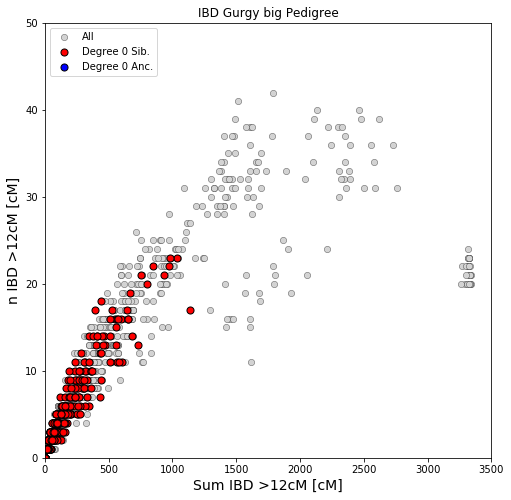

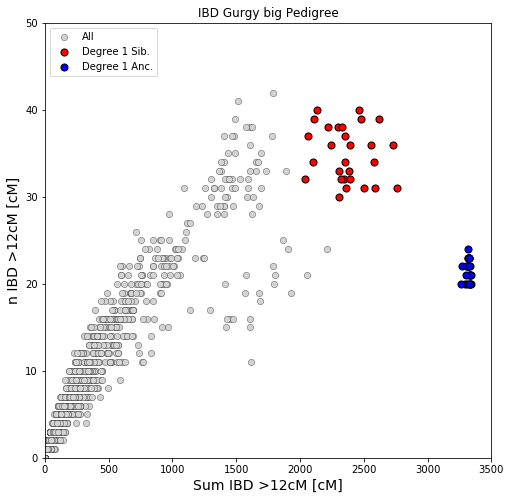

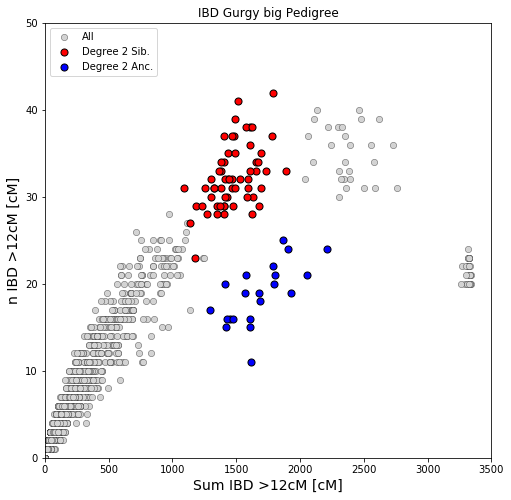

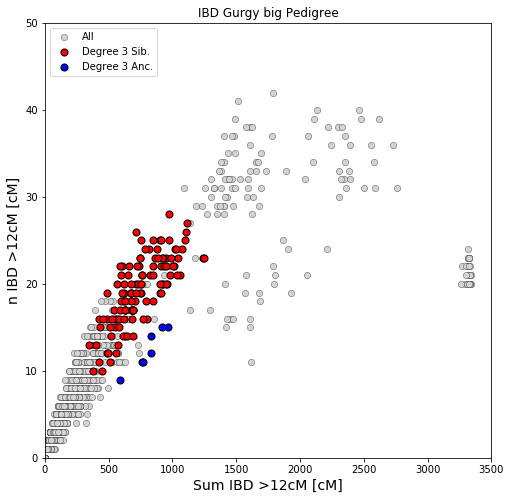

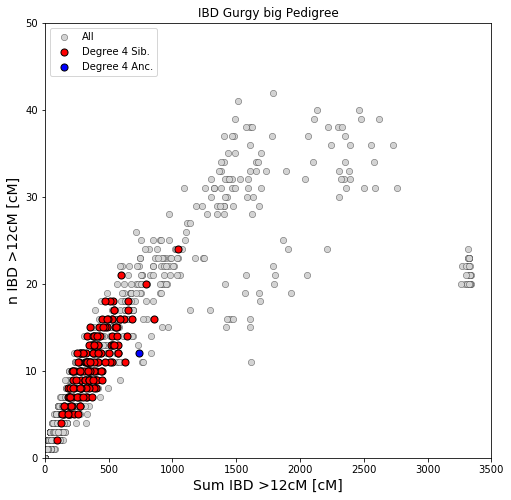

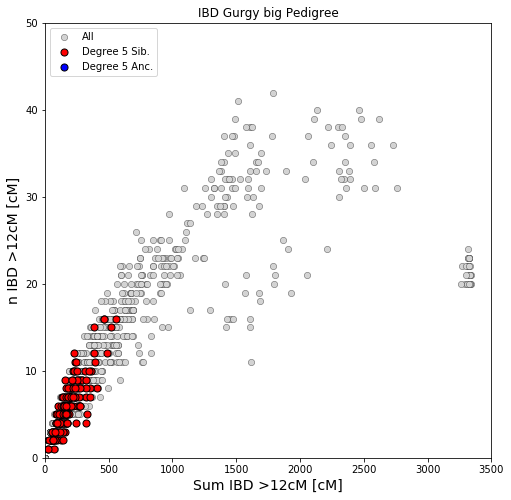

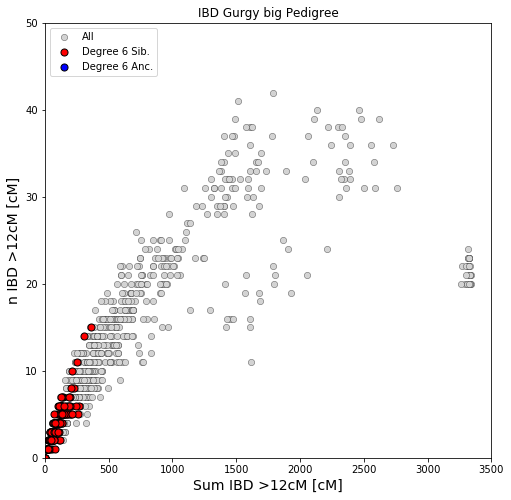

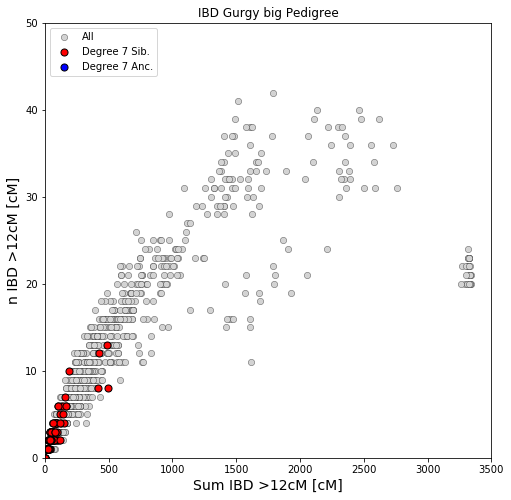

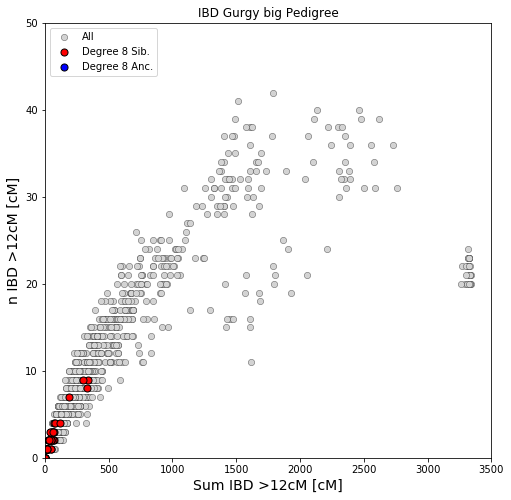

In [97]:
min_cm = 12
s = 50
s1= 40
savepath = ""
figsize = (8,8)
for r in range(0,9):
    savepath = f"./figs/ibd_scatter_rel{r}.png"
    savepath = ""

    plt.figure(figsize=figsize)
    ax = plt.gca()

    ax.scatter(df1[f"sum_IBD>{min_cm}"], df1[f"n_IBD>{min_cm}"], s=s1,
                   ec="k", linewidth=0.3, color="lightgray", label="All")

    dft = df1[(df1["rel"]==r) & (df1["anc"]==0)]
    ax.scatter(dft[f"sum_IBD>{min_cm}"], dft[f"n_IBD>{min_cm}"], s=s,
               ec="k", linewidth=1, color="red", label=f"Degree {r} Sib.")
    
    dft = df1[(df1["rel"]==r) & (df1["anc"]==1)]
    ax.scatter(dft[f"sum_IBD>{min_cm}"], dft[f"n_IBD>{min_cm}"], s=s,
               ec="k", linewidth=1, color="blue", label=f"Degree {r} Anc.")

    ax.set_xlabel(f"Sum IBD >{min_cm}cM [cM]", fontsize=14)
    ax.set_ylabel(f"n IBD >{min_cm}cM [cM]", fontsize=14)


    ax.legend(loc="upper left")
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
        print(f"Saved to {savepath}")
    ax.set_title("IBD Gurgy big Pedigree")
    
    ax.set_xlim([0,3500])
    ax.set_ylim([0,50])

    plt.show()

In [ ]:
dft.sort_values(by="sum_IBD>12", ascending=False)[:50]

In [ ]:
pd.merge(dft, df)

# Plot the full IBD distribution

# Screen for single IBD distribution

In [104]:
find_relatives(df1, iid="GRG079")

,iid1,iid2,rel,anc,max_IBD,sum_IBD>8,n_IBD>8,sum_IBD>12,n_IBD>12,sum_IBD>16,n_IBD>16,sum_IBD>20,n_IBD>20
0,GRG080,GRG079,0,0,119.815204,578.631901,15.0,557.304406,13.0,544.123506,12.0,544.123506,12.0
1,GRG034,GRG079,0,0,133.661902,590.841013,14.0,563.070112,11.0,550.852805,10.0,531.058204,9.0
2,GRG068,GRG079,0,0,79.673599,588.037387,18.0,554.517586,15.0,515.919490,12.0,515.919490,12.0
3,GRG079,GRG065,0,0,65.319788,536.477072,19.0,508.392671,16.0,465.705372,13.0,448.993768,12.0
4,GRG035,GRG079,0,0,88.484603,464.281496,14.0,452.496395,13.0,410.492790,10.0,392.429793,9.0
5,GRG079,GRG017,0,0,51.266903,393.833899,16.0,345.650392,11.0,317.282789,9.0,317.282789,9.0
6,GRG026,GRG079,0,0,70.880795,390.979706,13.0,361.193101,10.0,348.875801,9.0,314.391594,7.0
7,GRG057,GRG079,0,0,132.263801,384.307413,10.0,344.534411,6.0,332.317104,5.0,313.108704,4.0
8,GRG011,GRG079,0,0,58.648098,312.321191,9.0,302.648996,8.0,290.300895,7.0,290.300895,7.0
9,GRG002,GRG079,0,0,94.865295,294.524995,8.0,274.482496,6.0,247.325897,4.0,247.325897,4.0


In [103]:
find_relatives(df1, iid="GRG023")

,iid1,iid2,rel,anc,max_IBD,sum_IBD>8,n_IBD>8,sum_IBD>12,n_IBD>12,sum_IBD>16,n_IBD>16,sum_IBD>20,n_IBD>20


# Area 51

In [56]:
df1[df1["rel"]==0].sort_values(by="sum_IBD>12", ascending=False)[:20]

,iid1,iid2,rel,anc,max_IBD,sum_IBD>8,n_IBD>8,sum_IBD>12,n_IBD>12,sum_IBD>16,n_IBD>16,sum_IBD>20,n_IBD>20
1475,GRG048,GRG096,0,0,144.345701,1156.654668,19.0,1136.970675,17.0,1136.970675,17.0,1136.970675,17.0
198,GRG068,GRG010,0,0,128.816101,751.193386,15.0,730.172782,13.0,717.534487,12.0,717.534487,12.0
1416,GRG010,GRG017,0,0,115.350997,737.034589,20.0,681.544168,14.0,668.080968,13.0,649.314869,12.0
355,GRG067,GRG051,0,0,81.839001,697.407401,22.0,666.907101,19.0,637.909310,17.0,580.926710,14.0
715,GRG107,GRG010,0,0,88.031101,691.354595,20.0,653.576301,16.0,613.007902,13.0,577.875202,11.0
730,GRG107,GRG009,0,0,92.250501,652.718099,18.0,641.650601,17.0,583.830899,13.0,509.063901,9.0
213,GRG068,GRG009,0,0,106.021601,629.564195,14.0,603.771396,11.0,589.829296,10.0,589.829296,10.0
148,GRG043,GRG048,0,0,76.941097,637.220807,20.0,598.565191,16.0,544.426495,12.0,544.426495,12.0
1460,GRG048,GRG051,0,0,119.311596,628.071296,15.0,583.834195,11.0,583.834195,11.0,566.191197,10.0
1291,GRG080,GRG009,0,0,68.814194,592.333899,18.0,571.565686,16.0,556.615184,15.0,518.937787,13.0


In [86]:
df1